<a href="https://colab.research.google.com/github/kozoB/vit-pathmnist-classifier/blob/main/ViT_Medical_Imaging_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import importlib.util
import subprocess
import sys

# Install medmnist only if not already installed
if importlib.util.find_spec("medmnist") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "medmnist"])

import medmnist
from medmnist import PathMNIST
from medmnist import INFO

from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive

drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Masters Degree/Deep Learning Course'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load And Preprocess Dataset

In [3]:
data_flag = 'pathmnist'
download = True

# Load metadata
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

In [4]:
# Resize to 224x224 for ViT input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [5]:
from torch.utils.data import Dataset

class TransformedMedMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

In [6]:
train_dataset_raw = DataClass(split='train', download=download)
test_dataset_raw = DataClass(split='test', download=download)

train_dataset = TransformedMedMNIST(train_dataset_raw, transform=transform)
test_dataset = TransformedMedMNIST(test_dataset_raw, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


# Load Petrained Model

In [7]:
from transformers import ViTForImageClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    "facebook/deit-tiny-patch16-224",
    num_labels=9,
    ignore_mismatched_sizes=True
).to(device)

print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([9, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task 

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [8]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
!nvidia-smi

CUDA available: True
Current device: 0
Fri May 23 16:19:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             33W /   70W |     124MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------

In [9]:
from torch import nn
from torch.optim import AdamW

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-5)

# Model Training

In [10]:
from tqdm import tqdm

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.squeeze().to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.squeeze().to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            total_loss += loss.item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

## Training Loop And Save Best Model

In [11]:
EPOCHS = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float("inf")
patience = 2
wait = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        model.save_pretrained(save_path)  # Save best model
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break


Epoch 1: Train Loss = 0.1953, Train Acc = 0.9393, Val Loss = 0.3175, Val Acc = 0.8983
Epoch 2: Train Loss = 0.0678, Train Acc = 0.9787, Val Loss = 0.2399, Val Acc = 0.9304
Epoch 3: Train Loss = 0.0428, Train Acc = 0.9860, Val Loss = 0.2814, Val Acc = 0.9242
Epoch 4: Train Loss = 0.0322, Train Acc = 0.9900, Val Loss = 0.3100, Val Acc = 0.9237
Early stopping triggered.


# Accuracy And Loss Plots

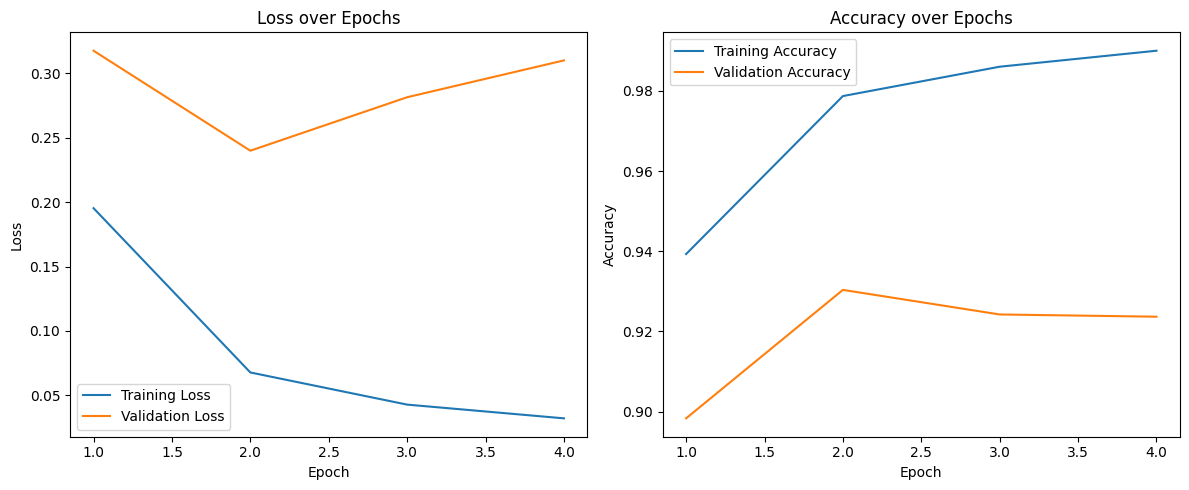

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Load Model From Drive

In [13]:
from google.colab import drive
from transformers import ViTForImageClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')
load_path = '/content/drive/MyDrive/Masters Degree/Deep Learning Course'

model = ViTForImageClassification.from_pretrained(load_path)
model.to(device)  # Move to GPU if available

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

# Evaluations

In [14]:
import importlib.util
import subprocess
import sys

# Install medmnist only if not already installed
if importlib.util.find_spec("medmnist") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "medmnist"])

import medmnist
from medmnist import PathMNIST
from medmnist import INFO

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Resize to 224x224 for ViT input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

class TransformedMedMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

data_flag = 'pathmnist'
download = True

# Load metadata
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

test_dataset_raw = DataClass(split='test', download=download)
test_dataset = TransformedMedMNIST(test_dataset_raw, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [15]:
class_names = [
    "Adipose", "Background", "Debris", "Lymphocytes", "Mucosa",
    "Smooth muscle", "Normal mucosa", "Stroma", "Tumor"
]

## Confusion Matrix

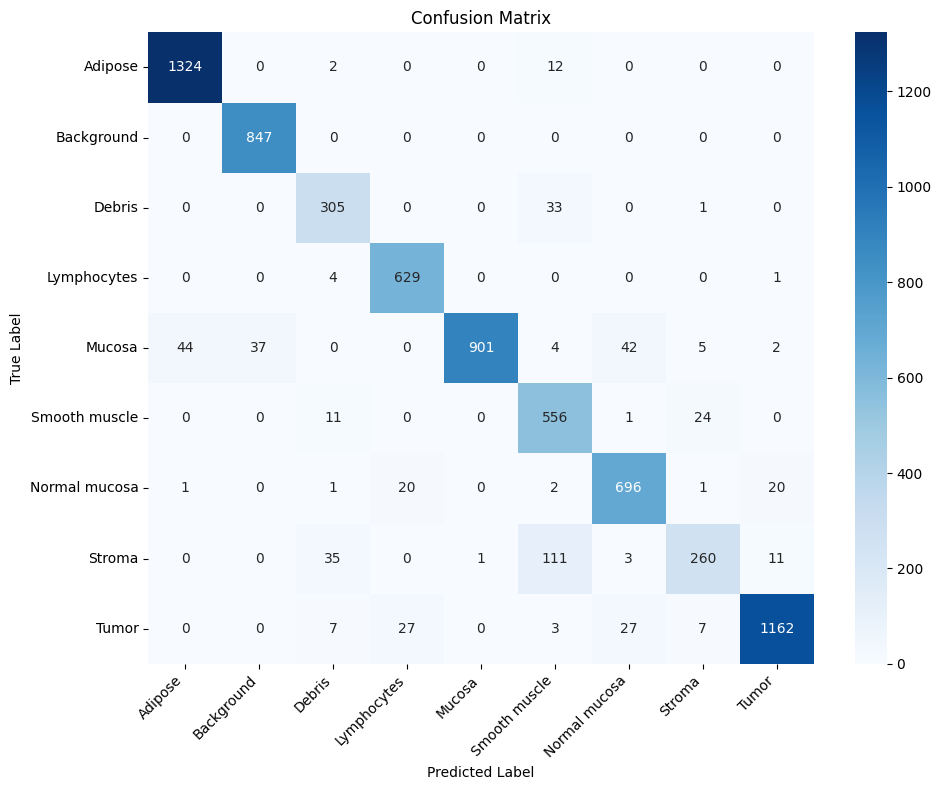

               precision    recall  f1-score   support

      Adipose     0.9671    0.9895    0.9782      1338
   Background     0.9581    1.0000    0.9786       847
       Debris     0.8356    0.8997    0.8665       339
  Lymphocytes     0.9305    0.9921    0.9603       634
       Mucosa     0.9989    0.8705    0.9303      1035
Smooth muscle     0.7712    0.9392    0.8469       592
Normal mucosa     0.9051    0.9393    0.9219       741
       Stroma     0.8725    0.6176    0.7232       421
        Tumor     0.9716    0.9424    0.9568      1233

     accuracy                         0.9304      7180
    macro avg     0.9123    0.9100    0.9070      7180
 weighted avg     0.9339    0.9304    0.9292      7180



In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Prediction collection function
def get_predictions(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.squeeze().cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
preds, true_labels = get_predictions(model, test_loader)

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report with Class Names
print(classification_report(true_labels, preds, target_names=class_names, digits=4))

## ROC, AUC Scores

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# One-hot encode true labels
y_true_bin = label_binarize(true_labels, classes=list(range(9)))  # For 9 classes

# Get probabilities instead of hard predictions
model.eval()
probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        logits = model(images).logits
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        probs.extend(prob)

# Compute ROC-AUC per class (macro-avg)
roc_auc = roc_auc_score(y_true_bin, np.array(probs), average="macro", multi_class="ovr")
print(f"Macro ROC-AUC: {roc_auc:.4f}")

Macro ROC-AUC: 0.9944


In [18]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

## Show Random Predictions From Test Set

In [19]:
def show_predictions(model, dataloader, num_samples=8):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(16, 8))

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break

                plt.subplot(2, num_samples // 2, images_shown + 1)
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5).clip(0, 1)  # unnormalize

                plt.imshow(img)
                pred_label = preds[i].item()
                true_label = labels[i].item()
                confidence = probs[i][pred_label].item()

                title_color = "green" if pred_label == true_label else "red"
                plt.title(
                    f"Pred: {class_names[pred_label]}\n"
                    f"True: {class_names[true_label]}\n"
                    f"Conf: {confidence*100:.1f}%",
                    color=title_color,
                    fontsize=10
                )
                plt.axis('off')
                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()

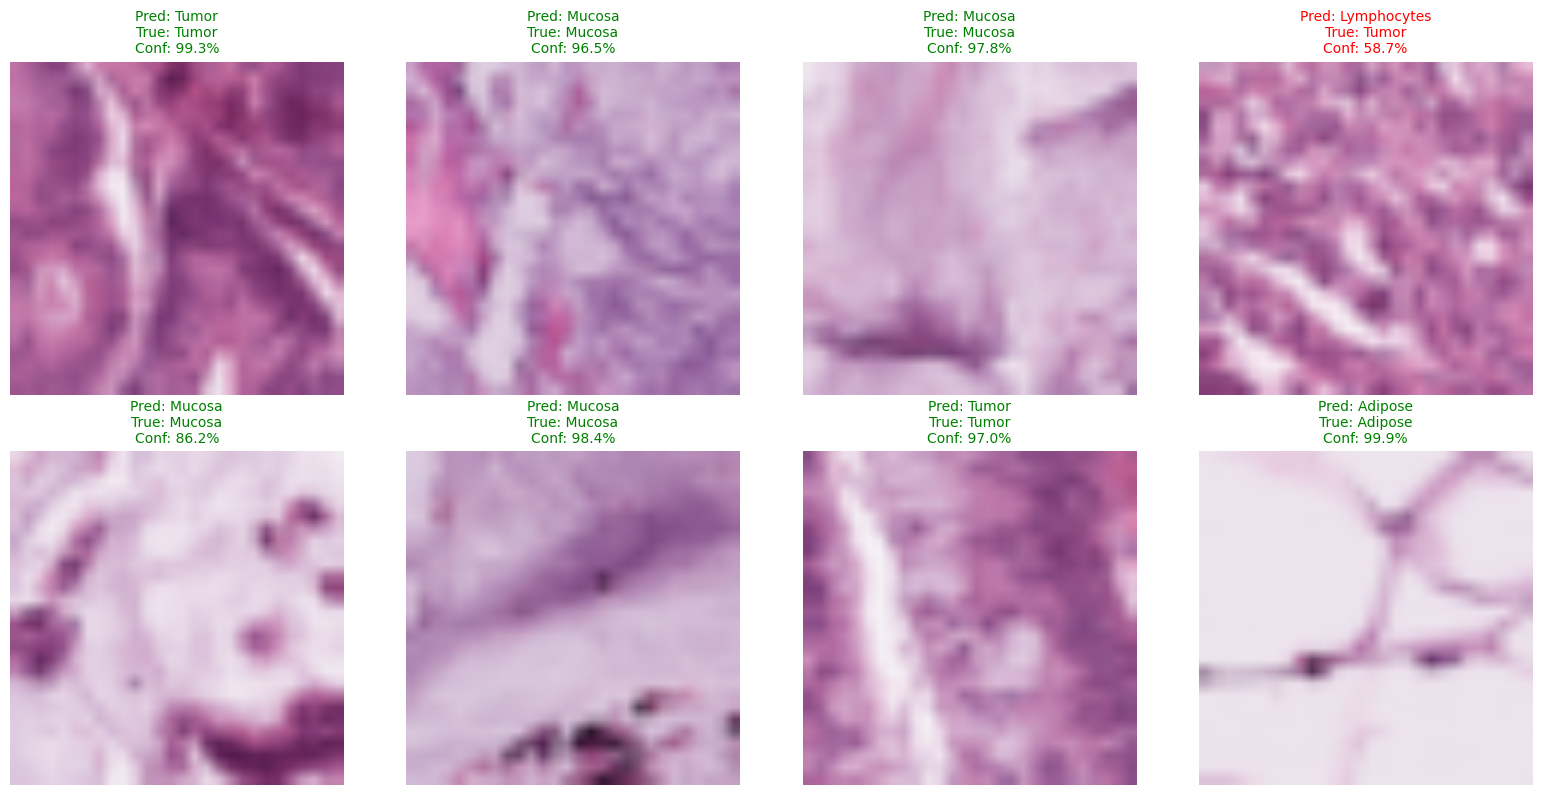

In [20]:
show_predictions(model, test_loader, num_samples=8)